In [1]:

# experimental mp data from OCHEM

import os
import xlrd
import pandas as pd
import numpy as np
from Util import *
from periodictable import elements
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [ ]:
#m=smile_to_mol("CCSC([C@H](C1)N(C)[C@@H]2CC1=O)[C@H]2O") #test
dfexcel = pd.read_excel(r"./melting_point_ochem_training_.xls")

In [ ]:
df=pd.DataFrame(dfexcel['SMILES'])
df.rename(columns={'SMILES':'Smiles'},inplace = True)
df['mp']=pd.DataFrame(dfexcel['Melting Point {measured, converted}'])


In [ ]:
# read file and convert to 3d-mol save to pkl.
df['m']=apply_parallel(df['Smiles'],smile_to_mol_df)             # apply_parallel smile_to_mol 
df.to_pickle("./temp_mp.pkl")

In [2]:
df=pd.read_pickle("./temp_mp.pkl")

In [3]:
df['m_text']=df['m'].apply(mol_to_text)
#df['shape']=df['m'].apply(get_mol_shape)
df['coord']=df['m_text'].apply(get_coordinate)               # get coordinate 
df['cm']=df['coord'].apply(coulomb_matrix)                   # get coulomb_matrix
df.dropna(subset=["cm"],inplace=True)                        # drop invaild data


In [4]:
# normalize & resize coulomb_matrix 
df['cm_length']=df['cm'].apply(len)
df['cm_norm']=df['cm']/max_num(df['cm'])
len_max=df['cm_length'].max()
df['cm_resize']=df['cm_norm'].apply(lambda x: vec_resize(x,len_max))

In [5]:
df

,Smiles,mp,m,m_text,coord,cm,cm_length,cm_norm,cm_resize
0,CN(C1=CC2=NC3=C(C=CC4=C3COCN4)C=C2C=C1)S(C)(=O)=O,300.0,<rdkit.Chem.rdchem.Mol object at 0x00000268762...,\n RDKit 3D\n\n 41 44 0 0 0 0...,"[[ C, 3.9098, 0.6017, -2.2427, 6], [ N, 3.8333...","[496.8368327930555, 235.49069343823595, 116.61...",41,"[0.053939861017344236, 0.025566412223361253, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,CNC1=CC=C2C=C3C=CC(=CC3=NC2=C1CO)N(C)S(C)(=O)=O,150.0,<rdkit.Chem.rdchem.Mol object at 0x00000268762...,\n RDKit 3D\n\n 43 45 0 0 0 0...,"[[ C, 6.3318, -2.3306, -1.262, 6], [ N, 4.9909...","[496.62552272791595, 231.79047551113936, 109.6...",43,"[0.053916919812520274, 0.025164692327516475, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,CCOC(=O)NC1=CC2=NC3=C(C=CC4=C3COCN4C(=O)OCC)C=...,174.0,<rdkit.Chem.rdchem.Mol object at 0x00000268762...,\n RDKit 3D\n\n 50 53 0 0 0 0...,"[[ C, 9.2308, 1.4015, 0.8329, 6], [ C, 7.7793,...","[332.77755216492244, 173.18322423220613, 119.7...",50,"[0.03612851086856625, 0.018801905231353312, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,CCOC(=O)NC1=CC=C2C=C3C=CC4=C(COC(=O)N4)C3=NC2=C1,235.0,<rdkit.Chem.rdchem.Mol object at 0x00000268762...,\n RDKit 3D\n\n 40 43 0 0 0 0...,"[[ C, 6.7335, 0.4513, -0.3518, 6], [ C, 6.1377...","[307.4023572515074, 163.3962206300079, 111.665...",40,"[0.03337361349265503, 0.017739364012114223, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,CCOC(=O)NC1=CC2=NC3=C(C=CC(N)=C3CO)C=C2C=C1,135.0,<rdkit.Chem.rdchem.Mol object at 0x00000268762...,\n RDKit 3D\n\n 40 42 0 0 0 0...,"[[ C, 7.7424, 1.3953, -1.5286, 6], [ C, 6.7597...","[289.4388709868566, 149.33320628954567, 95.493...",40,"[0.03142337975685263, 0.016212591057812326, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...
21878,CC(C)=CCC\C(C)=C/CO,50.0,<rdkit.Chem.rdchem.Mol object at 0x000002687F6...,\n RDKit 3D\n\n 29 28 0 0 0 0...,"[[ C, 4.0052, 0.1047, -0.1048, 6], [ C, 2.5267...","[176.42710282893958, 81.72911806554902, 59.757...",29,"[0.019154081940316876, 0.00887304841056754, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
21879,COC1=CC(OC)=NC(NC(=O)NS(=O)(=O)C2=C(C(O)=O)C(C...,176.0,<rdkit.Chem.rdchem.Mol object at 0x000002687F6...,\n RDKit 3D\n\n 40 41 0 0 0 0...,"[[ C, -5.2578, -3.4261, 1.7102, 6], [ O, -5.41...","[551.7332498140072, 219.42786289737379, 150.18...",40,"[0.05989977563924119, 0.023822526122871304, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
21880,CCCCOCCOC(=O)COC1=C(Cl)C=C(Cl)C(Cl)=N1,150.0,<rdkit.Chem.rdchem.Mol object at 0x000002687F6...,\n RDKit 3D\n\n 37 37 0 0 0 0...,"[[ C, 0.4995, 0.0303, -4.3431, 6], [ C, 0.1121...","[302.7832925187884, 104.47136372527032, 99.448...",37,"[0.032872137568834475, 0.01134209556878945, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
21881,C[C@]12C=CC3=C4CCC(=O)C=C4CC[C@H]3[C@@H]1CC[C@...,93.0,<rdkit.Chem.rdchem.Mol object at 0x000002687F6...,\n RDKit 3D\n\n 42 45 0 0 0 0...,"[[ C, -2.5709, 0.0645, -1.5666, 6], [ C, -2.30...","[266.0376091716432, 123.06224662754398, 76.826...",42,"[0.02888278548801174, 0.013360443593232412, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [6]:
# convert obj to df for tf
x_train=[]
for i in df['cm_resize']:                      # which column to use
    x_train.append(i)
dataset_all=pd.DataFrame(x_train)
dataset_all['mp']=df['mp']
dataset_all.dropna(inplace=True)
dataset_all.reset_index(drop=True)

,0,1,2,3,4,5,6,7,8,9,...,147,148,149,150,151,152,153,154,155,mp
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,300.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,150.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,174.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,235.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,135.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21780,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87.8
21781,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65.0
21782,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,360.0
21783,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0


In [7]:
for i in dataset_all.iloc[33]:
    print (i)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.026415847951262544
0.012325548257581104
0.009249350261738024
0.005723686929289743
0.004904175395877946
0.004223841262044804
0.003813637252445244
0.003547139798881808
0.002607757715108612
0.0021794390759367274
0.0014231605073719699
0.0013868675626730867
0.001075798940851714
0.0010512526208274425
0.0008155649952435621
0.0005137031949543995
0.00022118008615753677
-0.00011831056445637128
-0.00010379300448233208
-9.696418535059184e-05
-8.479191259831583e-05
-7.413418702637139e-05
-6.499411063291282e-05
-5.567088283124854e-05
-5.4411817693059196e-05
-4.669881971453172e-05
8.766837421710242e-06
4.698299744387644e-06
-3.258701000983463e-05
-2.8753342934637306e-05
-3.408130474705553e-06
-5.938168730776301e-06
-6.852132212855761e-06
-1.8408554187380753e-05
-

In [8]:
train_data=dataset_all.sample(frac=0.9,random_state=0)
test_data=dataset_all.drop(train_data.index)

train_labels=train_data.pop('mp')

train_data=train_data.reset_index(drop=True)
train_labels=train_labels.reset_index(drop=True)

test_labels=test_data.pop(('mp'))




In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [33]:
def build_model():
    model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_data.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(4, activation='relu'),
    layers.Dense(1)
         ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [34]:
model = build_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 64)                10048     
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 260       
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 5         
Total params: 14,473
Trainable params: 14,473
Non-trainable params: 0
_________________________________________________________________


In [39]:

class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 4000

history = model.fit(
  train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [43]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
3995,5849.123047,59.905384,5849.123047,9007.039062,70.907501,9007.039062,3995
3996,5912.391113,59.955391,5912.391113,9010.568359,70.413368,9010.568359,3996
3997,5863.362793,60.036972,5863.362793,9016.541992,70.185150,9016.541992,3997
3998,5869.268555,59.955650,5869.268555,9043.357422,71.057693,9043.357422,3998
3999,5861.615723,59.968212,5861.615723,9581.606445,73.283165,9581.606445,3999


In [44]:
import matplotlib.pyplot as plt
    

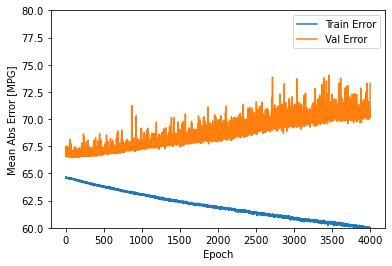

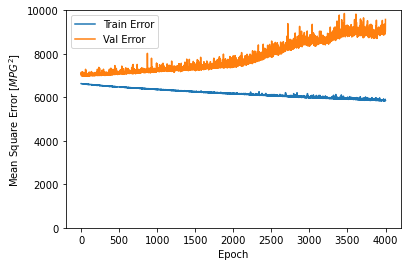

In [47]:
def plot_history(history):
      hist = pd.DataFrame(history.history)
      hist['epoch'] = history.epoch

      plt.figure()
      plt.xlabel('Epoch')
      plt.ylabel('Mean Abs Error [MPG]')
      plt.plot(hist['epoch'], hist['mae'],
               label='Train Error')
      plt.plot(hist['epoch'], hist['val_mae'],
               label = 'Val Error')
      plt.ylim([60,80])
      plt.legend()

      plt.figure()
      plt.xlabel('Epoch')
      plt.ylabel('Mean Square Error [$MPG^2$]')
      plt.plot(hist['epoch'], hist['mse'],
               label='Train Error')
      plt.plot(hist['epoch'], hist['val_mse'],
               label = 'Val Error')
      plt.ylim([0,10000])
      plt.legend()
      plt.show()


plot_history(history)